In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pvlib
from scipy.interpolate import interp1d

import csv

pd.plotting.register_matplotlib_converters()
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2,
                           'font.sans-serif':'Helvetica'
                           })



In [2]:
file = '727930TYA.CSV'

In [3]:
# read tmy metadata
with open(file, newline='') as f:
  reader = csv.reader(f)
  tmy_meta = next(reader)

lat = float(tmy_meta[4])
lon =float( tmy_meta[5])
elevation = float(tmy_meta[6])
tz = float(tmy_meta[3]) # Hours from Greenwich, negative west, Won't work with half hourly zones!

In [4]:
#### come back to this ###
tilt = 40
azimuth = 180

In [5]:
df = pd.read_csv(file, header = 1)

# presume everything happened in 2017, a non leap year
df.index = pd.DatetimeIndex(start = '01/01/2017 01:00:00', end = '01/01/2018 00:00:00', freq = 'H')

# Convert to UTC
df.index = df.index - pd.Timedelta(tz, unit='h')
df.index = df.index.tz_localize('UTC')

In [6]:
sun = pvlib.solarposition.get_solarposition(df.index, lat, lon, altitude=elevation)
aoi = pvlib.irradiance.aoi(tilt, azimuth, sun.apparent_zenith, sun.azimuth)

In [7]:
beam = df['DNI (W/m^2)']* np.cos(np.pi/180.0 * aoi)
beam = np.clip(beam, 0, None)
sky = pvlib.irradiance.isotropic(tilt, df['DHI (W/m^2)'])
poai = beam + sky

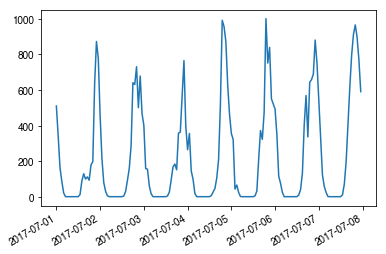

In [8]:
to_plot = poai['2017/07/01':'2017/07/07']
fig, ax = plt.subplots()
ax.plot(to_plot)
fig.autofmt_xdate()

In [9]:
min(df['ET'])

KeyError: 'ET'

In [ ]:
clearness_index = df['GHI (W/m^2)']/df['ETR (W/m^2)']
clearness_index = clearness_index.fillna(1)

In [ ]:
def sky_temp(dew_point, clearness_index, ambient_temperature):
    '''
    Calculate the sky temperature in Kelvins according to the model from
    
    Slauch, Ian, Michael Deceglie, Timothy Silverman, and Vivian E. Ferry
    "Spectrally-selective mirrors with combined optical and thermal benefit
    for photovoltaic module thermal management." ACS Photonics (2018)
    
    Paramaters
    ----------
    input temperatures in celcius
    
    clearness index = GHI/Extraterrestrial horizontal
    
    '''
    a = [123.1415, 11.3444, 4.2073, 0.4447] # coeffeciencts fit in Golden
    
    # Tetens equation for vapor pressure
    Pw = 6.1078 * np.exp((17.27 * dew_point)/(dew_point + 237.3))
    
    TskyEst = a[0] + a[1] * np.log(Pw) - a[2] * clearness_index + a[3] * (ambient_temperature + 273.15)
    
    return TskyEst

In [10]:
def ground_temp(ambient_temperature, GHI):
    '''
    Calculate the ground temperature in Kelvins according to the model from
    
    Slauch, Ian, Michael Deceglie, Timothy Silverman, and Vivian E. Ferry
    "Spectrally-selective mirrors with combined optical and thermal benefit
    for photovoltaic module thermal management." ACS Photonics (2018)
    
    Paramaters
    ----------
    ambient_temperature is in celcius
    GHI is in w/m^2
    '''
    ground_temperature = ambient_temperature - 1.362 + 1.287e-2*GHI + 273.15
    
    return ground_temperature

In [11]:
def projected_sun_elevation(elevation, aziumth):
    '''
    Calculates sun projected elevation in radians from
    elevation and azimuth, both in radians
    '''
    projected = np.clip(np.arctan2(np.tan(elevation), -np.cos(azimuth)), 0., np.pi)
    return projected

In [12]:
# projected_sun_elevation(sun['apparent_elevation']*np.pi/180.0, sun['azimuth']*np.pi/180.0)

In [21]:
optics = pd.read_csv('module_optics.csv')
diffuse = optics[optics['angle']=='diffuse'].to_dict(orient='records')[0]
optics = optics[optics['angle']!='diffuse'].copy()
optics['angle'] = optics['angle'].apply(float)

In [36]:
def hemi_ave(theta, y, lower_limit = 0, upper_limt = 90, step = 1):
    '''
    Numerical hemispherical avarage as for a function y(theta) where theta is
    the zenith in degrees.
    '''
    
    y_interp = interp1d(theta, y, fill_value='extrapolate')
    
    theta_grid = np.arange(lower_limit, upper_limit+step/10.0, step)
    y_grid = y_interp(theta_grid)
    
    theta_grid = np.deg2rad(theta_grid)
    
    ave = np.trapz(y_grid*np.sin(theta_grid), theta_grid)/ np.trapz(np.sin(theta_grid), theta_grid)
    
    return ave
    

In [38]:
diffuse

{'angle': 'diffuse',
 'cell_abs_W/m2': 407.7947506,
 'current_derate': 0.48486303,
 'encapsulant_abs_W/m2': 23.81071058,
 'glass_abs_W/m2': 9.290157852}

In [42]:
diffuse = {
    'cell_abs_W/m2': hemi_ave(optics['angle'], optics['cell_abs_W/m2']),
    'encapsulant_abs_W/m2': hemi_ave(optics['angle'], optics['encapsulant_abs_W/m2']),
    'glass_abs_W/m2': hemi_ave(optics['angle'], optics['glass_abs_W/m2']),
    'current_derate': hemi_ave(optics['angle'], optics['current_derate'])
}

In [43]:
diffuse

{'cell_abs_W/m2': 396.08493128712894,
 'current_derate': 0.4709109622443262,
 'encapsulant_abs_W/m2': 23.097974642358977,
 'glass_abs_W/m2': 9.005581857603806}

In [17]:
lower_limit= 0
upper_limit = 90
step = 1

theta_grid = np.arange(lower_limit, upper_limit+step/10.0, step)

In [18]:
theta_grid

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.])

In [88]:
diffuse

{'angle': 'diffuse',
 'cell_abs_W/m2': 407.7947506,
 'current_derate': 0.48486303,
 'encapsulant_abs_W/m2': 23.81071058,
 'glass_abs_W/m2': 9.290157852}

In [22]:
# Interpolations for each column in optics
interp_kwargs = {'fill_value':'extrapolate', 'kind':'linear'}
glass_abs = interp1d(optics['angle'], optics['glass_abs_W/m2'], **interp_kwargs )
encapsulant_abs = interp1d(optics['angle'], optics['encapsulant_abs_W/m2'], **interp_kwargs )
cell_abs = interp1d(optics['angle'], optics['cell_abs_W/m2'], **interp_kwargs )
current_derate = interp1d(optics['angle'], optics['current_derate'], **interp_kwargs )

In [20]:
out = pd.DataFrame()

out['temp'] = df['Dry-bulb (C)'] + 273.15
out['temp_sky'] = sky_temp(df['Dew-point (C)'], clearness_index, df['Dry-bulb (C)'])
out['temp_ground'] = ground_temp(df['Dry-bulb (C)'], df['GHI (W/m^2)'])
out['poai'] = poai
out['dni'] = df['DNI (W/m^2)']
out['wind_speed'] = df['Wspd (m/s)']
out['elevation_projected'] = projected_sun_elevation(sun['apparent_elevation']*np.pi/180.0, sun['azimuth']*np.pi/180.0)

out['abs_glass'] = glass_abs(aoi) * beam / 1000.0 + diffuse['glass_abs_W/m2'] * sky / 1000.0
out['abs_cell'] = cell_abs(aoi) * beam / 1000.0 + diffuse['cell_abs_W/m2'] * sky / 1000.0
out['abs_encapsulant'] = encapsulant_abs(aoi) * beam / 1000.0 + diffuse['encapsulant_abs_W/m2'] * sky / 1000.0
out['current_factor'] = current_derate(aoi) * beam/poai + diffuse['current_derate'] * sky/poai
out['current_factor'] = out['current_factor'].fillna(0.0)

out['elapsed'] = (out.index - out.index[0]).astype(np.timedelta64())/1e9
out.set_index('elapsed', inplace=True)

NameError: name 'sky_temp' is not defined

array([1, 2, 3, 4])

In [132]:
out

,temp,temp_sky,temp_ground,poai,dni,wind_speed,elevation_projected,abs_glass,abs_cell,abs_encapsulant,current_factor
elapsed,,,,,,,,,,,
0.0,278.15,264.549510,276.78800,0.000000,0,5.7,0.000000,0.000000,0.000000,0.000000,0.000000
3600.0,278.15,265.440708,276.78800,0.000000,0,5.7,0.000000,0.000000,0.000000,0.000000,0.000000
7200.0,278.15,265.440708,276.78800,0.000000,0,4.1,0.000000,0.000000,0.000000,0.000000,0.000000
10800.0,278.75,266.109925,277.38800,0.000000,0,5.2,0.000000,0.000000,0.000000,0.000000,0.000000
14400.0,279.25,266.812948,277.88800,0.000000,0,4.1,0.000000,0.000000,0.000000,0.000000,0.000000
18000.0,280.95,267.967676,279.58800,0.000000,0,6.2,0.000000,0.000000,0.000000,0.000000,0.000000
21600.0,279.85,268.428779,278.48800,0.000000,0,3.6,0.000000,0.000000,0.000000,0.000000,0.000000
25200.0,279.85,268.428779,278.48800,0.000000,0,5.7,0.003714,0.000000,0.000000,0.000000,0.000000
28800.0,280.95,272.153652,279.72957,11.947814,4,4.6,0.214428,0.114621,4.964164,0.292035,0.494219


In [127]:
3600000000000/(60*60)

1000000000.0

In [1]:
from tomcat_tmy import generate_input

In [2]:
test = generate_input('727930TYA.CSV', 'module_optics.csv')

In [3]:
test

,temp,temp_sky,temp_ground,poai,dni,wind_speed,elevation_projected,abs_glass,abs_cell,abs_encapsulant,current_factor
elapsed,,,,,,,,,,,
0.0,278.15,264.549510,276.78800,0.000000,0,5.7,0.000000,0.000000,0.000000,0.000000,0.000000
3600.0,278.15,265.440708,276.78800,0.000000,0,5.7,0.000000,0.000000,0.000000,0.000000,0.000000
7200.0,278.15,265.440708,276.78800,0.000000,0,4.1,0.000000,0.000000,0.000000,0.000000,0.000000
10800.0,278.75,266.109925,277.38800,0.000000,0,5.2,0.000000,0.000000,0.000000,0.000000,0.000000
14400.0,279.25,266.812948,277.88800,0.000000,0,4.1,0.000000,0.000000,0.000000,0.000000,0.000000
18000.0,280.95,267.967676,279.58800,0.000000,0,6.2,0.000000,0.000000,0.000000,0.000000,0.000000
21600.0,279.85,268.428779,278.48800,0.000000,0,3.6,0.000000,0.000000,0.000000,0.000000,0.000000
25200.0,279.85,268.428779,278.48800,0.000000,0,5.7,0.003907,0.000000,0.000000,0.000000,0.000000
28800.0,280.95,272.153652,279.72957,11.947814,4,4.6,0.178803,0.111857,4.850423,0.285112,0.482876
